Validating AI generated translation with expert translation

In [1]:
import pandas as pd
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize
from jiwer import wer
from comet import download_model, load_from_checkpoint
import torch
import os

c:\Users\robin\anaconda3\envs\text-processing\lib\site-packages\torchmetrics\utilities\imports.py:23: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


In [2]:
def calculate_bleu(reference, hypothesis):
    """
    Calculates the BLEU score for a single hypothesis against a reference,
    using a smoothing function to avoid zero scores for short sentences.
    - reference: The reference translation (string).
    - hypothesis: The machine-generated translation (string).
    - Returns: BLEU score (float).
    """
    # NLTK expects a list of tokenized references and a tokenized hypothesis
    reference_tokens = [word_tokenize(str(reference).lower())]
    hypothesis_tokens = word_tokenize(str(hypothesis).lower())
    
    # Instantiate a smoothing function. Method1 is a simple 'add-epsilon' smoothing.
    # This helps prevent scores of 0 for sentences with no higher-order n-gram matches.
    smoothing_function = SmoothingFunction().method1
    
    # Calculate BLEU score with the smoothing function
    return sentence_bleu(
        reference_tokens,
        hypothesis_tokens,
        smoothing_function=smoothing_function
    )

def calculate_meteor(reference, hypothesis):
    """
    Calculates the METEOR score.
    - reference: The reference translation (string).
    - hypothesis: The machine-generated translation (string).
    - Returns: METEOR score (float).
    """
    # NLTK's meteor_score expects tokenized inputs
    reference_tokens = word_tokenize(reference.lower())
    hypothesis_tokens = word_tokenize(hypothesis.lower())
    # Use a list for references as per meteor_score documentation, although we have one.
    return meteor_score([reference_tokens], hypothesis_tokens)

def calculate_wer(reference, hypothesis):
    """
    Calculates 1-WER (Word Accuracy Rate) for consistency with other metrics.
    - reference: The reference translation (string).
    - hypothesis: The machine-generated translation (string).
    - Returns: 1-WER score (float) where higher is better.
    """
    return 1 - wer(reference, hypothesis)



In [3]:
# -----------------------------  configuration  ------------------------------
csv_file_path   = r"D:\SOKM\01 Introduction SoKM 2024 - 2025 transcript_translation_Proofread.csv"
source_column   = "Segment Text"
reference_column = "Translation_nativespeaker"

# -----------------------------  load data  ----------------------------------
df = pd.read_csv(csv_file_path, encoding="latin1")

# detect hypothesis columns
hypothesis_columns = (
    df.columns
      .str.startswith("Translation_") &
    ~df.columns.isin([reference_column])
)
hypothesis_columns = df.columns[hypothesis_columns].tolist()

if not hypothesis_columns:
    raise ValueError("No hypothesis columns starting with 'Translation_' found.")

print(f"Found hypothesis columns: {hypothesis_columns}")

# drop rows with missing data in any essential column
essential_cols = [source_column, reference_column] + hypothesis_columns
df.dropna(subset=essential_cols, inplace=True)
print(f"Processing {len(df)} rows after dropping NA values.")

# -----------------------------  COMET model  --------------------------------
print("Loading COMET model …")
model_path = download_model("Unbabel/wmt22-comet-da")
comet_model = load_from_checkpoint(model_path)
use_gpu = 1 if torch.cuda.is_available() else 0
print(f"COMET loaded (GPU={'yes' if use_gpu else 'no'}).")

# ---------------------------  metric calculation  ---------------------------
summary_rows = []

for hyp_col in hypothesis_columns:
    print(f"Calculating metrics for '{hyp_col}' …")
    # row-wise lists
    bleu_scores   = []
    meteor_scores = []
    wer_scores    = []

    # COMET needs dicts
    comet_data = []

    for src, ref, hyp in zip(df[source_column], df[reference_column], df[hyp_col]):
        bleu_scores  .append(calculate_bleu(ref, hyp))
        meteor_scores.append(calculate_meteor(ref, hyp))
        wer_scores   .append(calculate_wer  (ref, hyp))
        comet_data.append({"src": src, "mt": hyp, "ref": ref})

    # COMET predictions in a single batch
    comet_scores = comet_model.predict(comet_data,
                                       batch_size=16,
                                       gpus=use_gpu).scores

    # -------------  attach row-level scores to df  -------------
    df[f"BLEU_{hyp_col}"]   = bleu_scores
    df[f"METEOR_{hyp_col}"] = meteor_scores
    df[f"1-WER_{hyp_col}"]  = wer_scores  # Now contains 1-WER values
    df[f"COMET_{hyp_col}"]  = comet_scores

    # -------------  collect averages for summary  --------------
    summary_rows.append({
        "hypothesis_column": hyp_col,
        "avg_BLEU"  : sum(bleu_scores)   / len(bleu_scores),
        "avg_METEOR": sum(meteor_scores) / len(meteor_scores),
        "avg_1-WER" : sum(wer_scores)    / len(wer_scores),  # Now 1-WER
        "avg_COMET" : sum(comet_scores)  / len(comet_scores),
    })

# ---------------------------  write outputs  --------------------------------
base, ext = os.path.splitext(csv_file_path)
row_metrics_path     = f"{base}_row_metrics{ext}"
summary_metrics_path = f"{base}_summary_metrics{ext}"

df.to_csv(row_metrics_path, index=False)
pd.DataFrame(summary_rows).to_csv(summary_metrics_path, index=False)

print("\n✔ Evaluation finished.")
print(f"• Row-level metrics saved to  : {row_metrics_path}")
print(f"• Column-level summary saved to: {summary_metrics_path}")

Found hypothesis columns: ['Translation_deepl', 'Translation_Hellsinki', 'Translation_chatgpt4o_mini', 'Translation_chatgpt4o']
Processing 646 rows after dropping NA values.
Loading COMET model …


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Encoder model frozen.
c:\Users\robin\anaconda3\envs\text-processing\lib\site-packages\pytorch_lightning\core\saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
c:\Users\robin\anaconda3\envs\text-processing\lib\site-packages\pytorch_lightning\core\saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']


COMET loaded (GPU=yes).
Calculating metrics for 'Translation_deepl' …


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Predicting DataLoader 0: 100%|██████████| 41/41 [00:06<00:00,  6.07it/s]



Calculating metrics for 'Translation_Hellsinki' …


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Predicting DataLoader 0: 100%|██████████| 41/41 [00:06<00:00,  6.45it/s]



Calculating metrics for 'Translation_chatgpt4o_mini' …


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Predicting DataLoader 0: 100%|██████████| 41/41 [00:06<00:00,  6.34it/s]



Calculating metrics for 'Translation_chatgpt4o' …


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Predicting DataLoader 0: 100%|██████████| 41/41 [00:06<00:00,  6.31it/s]




✔ Evaluation finished.
• Row-level metrics saved to  : D:\SOKM\01 Introduction SoKM 2024 - 2025 transcript_translation_Proofread_row_metrics.csv
• Column-level summary saved to: D:\SOKM\01 Introduction SoKM 2024 - 2025 transcript_translation_Proofread_summary_metrics.csv


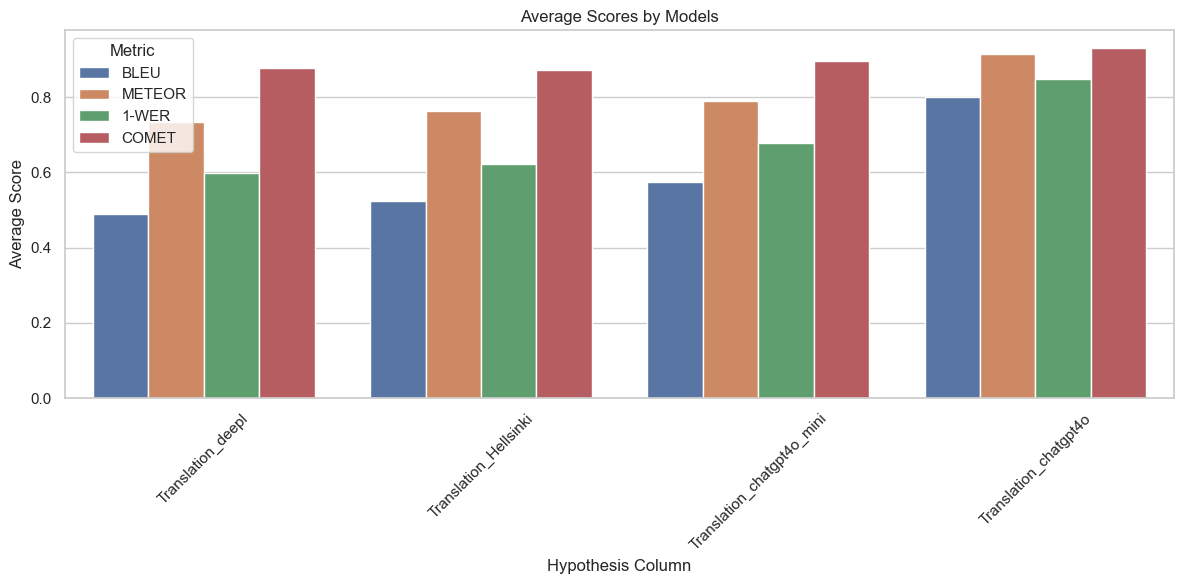

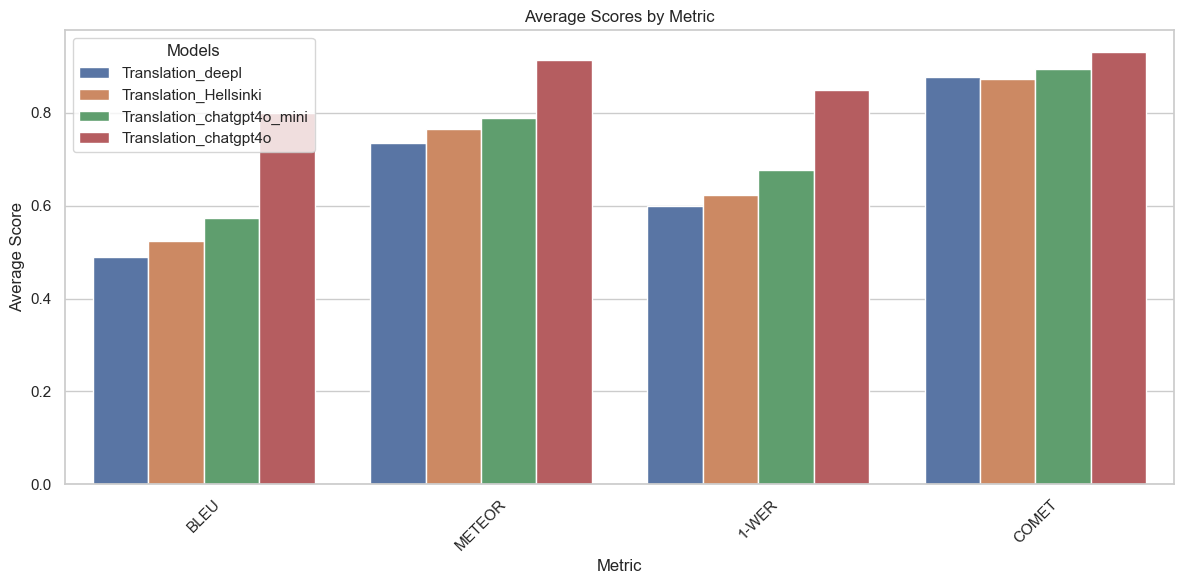

In [4]:
# Create a grouped plot of the average scores
import matplotlib.pyplot as plt
import seaborn as sns

# Convert summary rows to DataFrame for plotting
summary_df = pd.DataFrame(summary_rows)
# Melt the DataFrame to long format for easier plotting
summary_long = summary_df.melt(id_vars='hypothesis_column', 
                                value_vars=['avg_BLEU', 'avg_METEOR', 'avg_1-WER', 'avg_COMET'],
                                var_name='Metric', value_name='Score')
# Set the style for seaborn
sns.set(style="whitegrid")

# No need to convert WER scores anymore since they're already 1-WER
# Rename the metrics for clarity
summary_long['Metric'] = summary_long['Metric'].replace({
    'avg_BLEU': 'BLEU',
    'avg_METEOR': 'METEOR',
    'avg_1-WER': '1-WER',
    'avg_COMET': 'COMET'
})

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=summary_long, x='hypothesis_column', y='Score', hue='Metric')
plt.title('Average Scores by Models')
plt.xlabel('Hypothesis Column')
plt.ylabel('Average Score')
plt.xticks(rotation=45)
plt.legend(title='Metric')
plt.tight_layout()

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=summary_long, x='Metric', y='Score', hue='hypothesis_column')
plt.title('Average Scores by Metric')
plt.xlabel('Metric')
plt.ylabel('Average Score')
plt.xticks(rotation=45)
plt.legend(title='Models')
plt.tight_layout()
